# PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## PaleoSTeHM Illustrative Examples for Temporal Modelling 

In [3]:
import sys
sys.path.append('../Code')
import PSTHM 
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import warnings
from scipy import interpolate

warnings.filterwarnings("ignore")
#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)

### Data loading

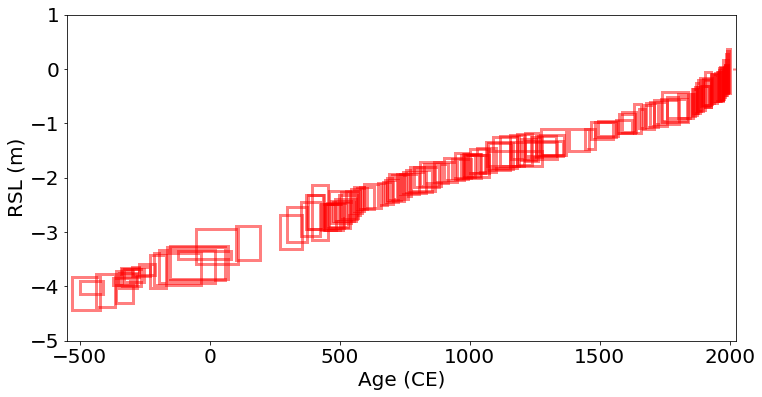

In [5]:

#load data 
X,y,y_sigma,x_sigma,lon,lat = PSTHM.load_local_rsl_data('../Data/NJ_CC.csv')
X,X_index = torch.sort(X)
y = y[X_index]
y_sigma = y_sigma[X_index]
x_sigma = x_sigma[X_index]
lon = torch.tensor(lon)[X_index]
lat = torch.tensor(lat)[X_index]
#visualize data
ax = PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

### 1. Bayesian Linear Regression 

  0%|          | 0/2000 [00:00<?, ?it/s]

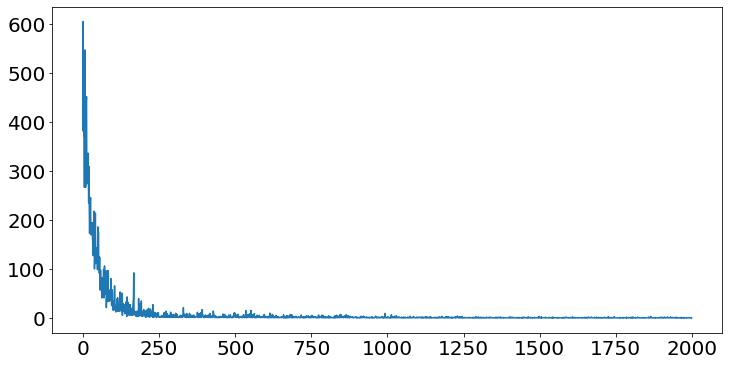

In [6]:
import pyro.distributions as dist

#------Define the process mdoel---------
linear_model = PSTHM.linear_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
#you can change the prior distribution here to see how it affects the model!
intercept_prior = dist.Uniform(-5., 5.)
coefficient_prior = dist.Uniform(-0.01,0.01)
#-------Optimize parameter model---------
guide,losses = PSTHM.opti_pyro_model(linear_model,test_X,y,x_sigma,y_sigma,intercept_prior,coefficient_prior,lr=0.02)
#-------Visualize the training loss---------
plt.plot(losses);

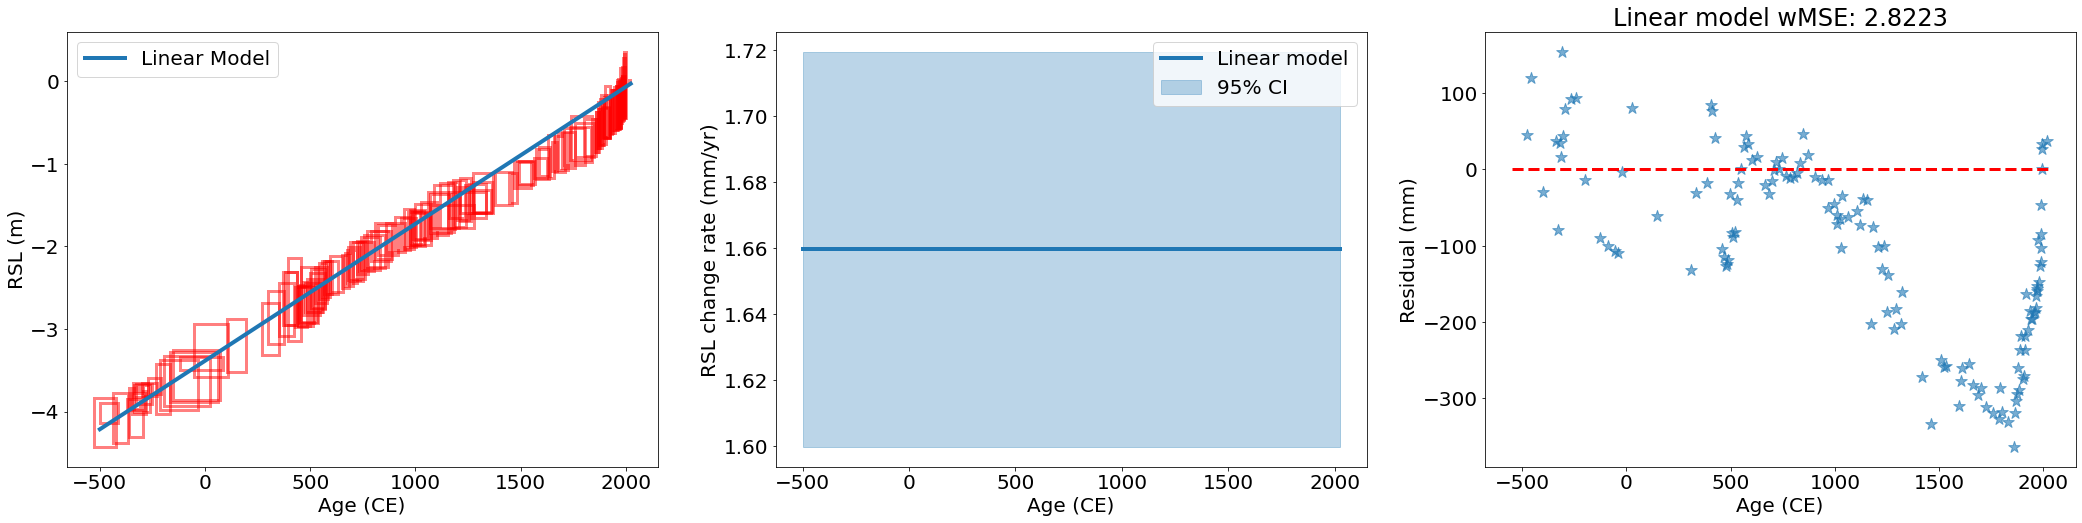

In [8]:
#-------Visualize the optimized model---------
#estimate the posterior distribution of the model parameters from optimized model 
pred_x = torch.tensor([-500,2023])
sample_number = 500 #number of samples to draw from the posterior distribution
a_dis,b_dis,y_pred = torch.zeros(sample_number),torch.zeros(sample_number),torch.zeros(sample_number,len(pred_x))
for i in range(sample_number):
    test_b,test_a,_ = guide().values()
    y_pred[i] = pred_x*test_a + test_b
    a_dis[i] = test_a
    b_dis[i] = test_b
y_pred = y_pred.detach().numpy()
a_dis = a_dis.detach().numpy()
b_dis = b_dis.detach().numpy()

a_mean,a_std = np.mean(a_dis),np.std(a_dis)
b_mean,b_std = np.mean(b_dis),np.std(b_dis)
mean_pred = np.mean(y_pred,axis=0)

#--------visualize modelled RSL, RSL change rate and model residual-----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(pred_x,mean_pred,color='C0',linewidth=4,label='Linear Model')
# ax.set_xlim(-550,2025)
# ax.set_ylim(-5,1)
plt.legend()

ax2 = plt.subplot(132)
plt.plot(pred_x,[a_mean*1000,a_mean*1000],color='C0',linewidth=4,label='Linear model')
plt.fill_between(pred_x,(a_mean-2*a_std)*1000,(a_mean+2*a_std)*1000,color='C0',alpha=0.3,label='95% CI')
plt.ylabel('RSL change rate (mm/yr)')
plt.xlabel('Age (CE)')
plt.legend()

ax3 = plt.subplot(133)
f_linear= interpolate.interp1d(pred_x,mean_pred)
linear_prediction = f_linear(X)
plt.scatter(X,(y.detach().numpy()-linear_prediction)*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')

plt.ylabel('Residual (mm)')
plt.title('Linear model wMSE: {:4.4f}'.format(PSTHM.cal_wMSE(y.detach().numpy(),linear_prediction,y_sigma.detach().numpy())))
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)

plt.show()



### 2. Change-point model

  0%|          | 0/2000 [00:00<?, ?it/s]

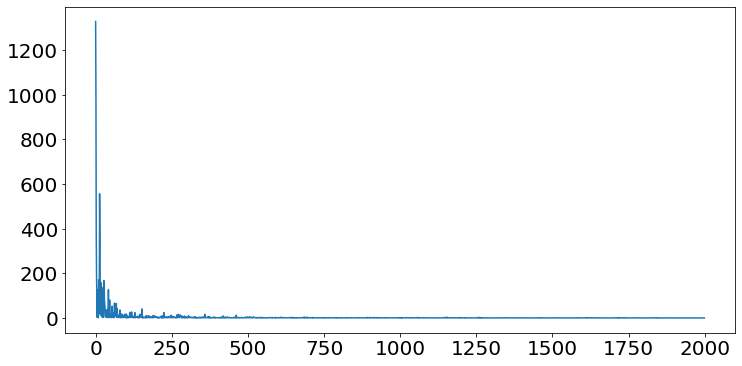

In [9]:
import pyro.distributions as dist

#------Define the process mdoel---------
change_point_model = PSTHM.change_point_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
intercept_prior = dist.Uniform(-7., -2.)  #prior distribution for b
coefficient_prior = dist.Uniform(-0.01,0.01) #prior distribution for A

num_change_points = 2
guide,losses = PSTHM.opti_pyro_model(change_point_model,test_X,y,x_sigma,y_sigma,num_change_points,intercept_prior,coefficient_prior,lr=0.05,number_of_steps=2000)
#-------Visualize the training loss---------
plt.plot(losses);

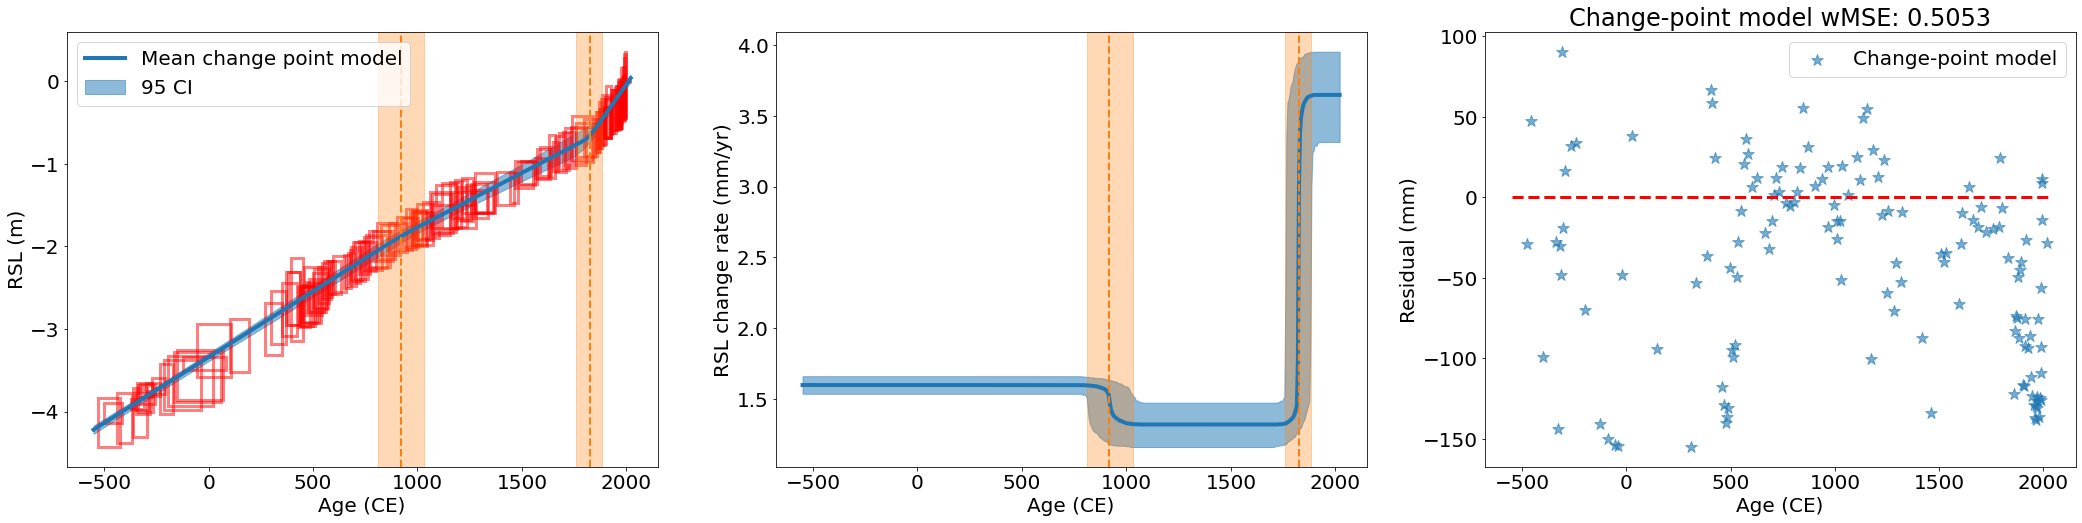

In [11]:
#get posterior distributin
posterior = PSTHM.get_change_point_posterior(guide,1000)

#-------Calculate posterior predictive and sea-level change rate-------
forward_x = torch.arange(-550,2025,5)
change_point_pred = np.zeros([1000,len(forward_x)])
change_point_pred_rate = np.zeros([1000,len(forward_x)])

for i in range(1000):
    change_point_pred[i,:] = PSTHM.change_point_forward(num_change_points,posterior['cp'][i],forward_x[:,None],test_X,posterior['a'][i],posterior['b'][i])
    change_point_pred_rate[i] = np.gradient(change_point_pred[i],forward_x)
change_point_pred_2p5,change_point_pred_50,change_point_pred_97p5 = np.percentile(change_point_pred,[2.5,50,97.5],axis=0)
change_point_pred_rate_2p5,change_point_pred_rate_50,change_point_pred_rate_97p5 = np.percentile(change_point_pred_rate,[2.5,50,97.5],axis=0)*1000
#------------Visualize the change point model----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(forward_x,change_point_pred_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_2p5,change_point_pred_97p5,color='C0',alpha=0.5,label='95 CI')

for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)
plt.legend()
ax2 = plt.subplot(132)
# plot_time = [X.min(),*posterior['cp'].mean(axis=0),forward_x.max()]
# for i in range(posterior['a'].shape[1]):
#     a_2p5,a_50,a_97p5 = np.percentile(posterior['a'][:,i],[2.5,50,97.5])*1000
#     plt.plot(plot_time[i:i+2],[a_50,a_50],color='C0',linewidth=4)
#     plt.fill_between(plot_time[i:i+2],[a_2p5,a_2p5],[a_97p5,a_97p5],color='C0',alpha=0.3)
plt.plot(forward_x,change_point_pred_rate_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_rate_2p5,change_point_pred_rate_97p5,color='C0',alpha=0.5,label='95 CI')
for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)
plt.xlabel('Age (CE)')
plt.ylabel('RSL change rate (mm/yr)')

ax3 = plt.subplot(133)
f_cp = interpolate.interp1d(forward_x,change_point_pred_50)
cp_prediction = f_cp(X)
ax3.scatter(X,(y.detach().numpy()-cp_prediction)*1000,s=150,marker='*',color='C0',alpha=0.6,label = 'Change-point model')

plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.legend()
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)

plt.title('Change-point model wMSE: {:4.4f}'.format(PSTHM.cal_wMSE(y.detach().numpy(),cp_prediction,y_sigma.detach().numpy())));


### 3. Gaussian Process Model

  0%|          | 0/1000 [00:00<?, ?it/s]

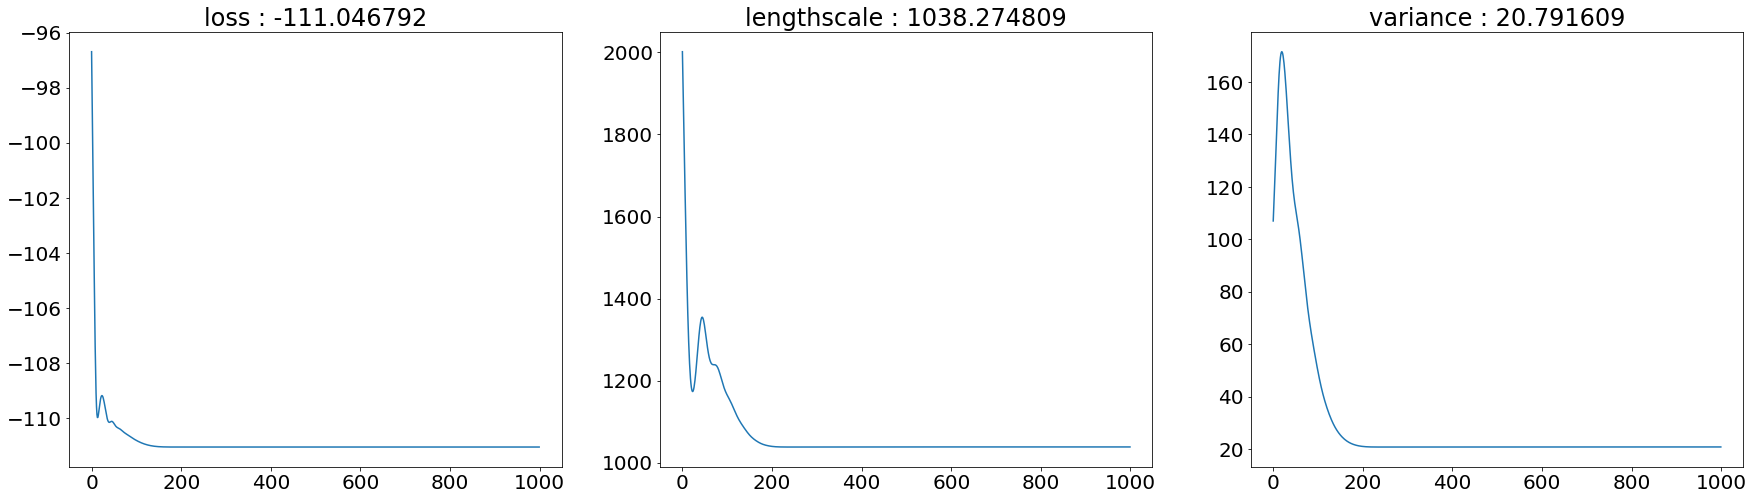

In [12]:
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))
#set prior distribution for kernels
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(5000.)))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma,num_iteration=1000)

axes = PSTHM.plot_track_list(track_list)

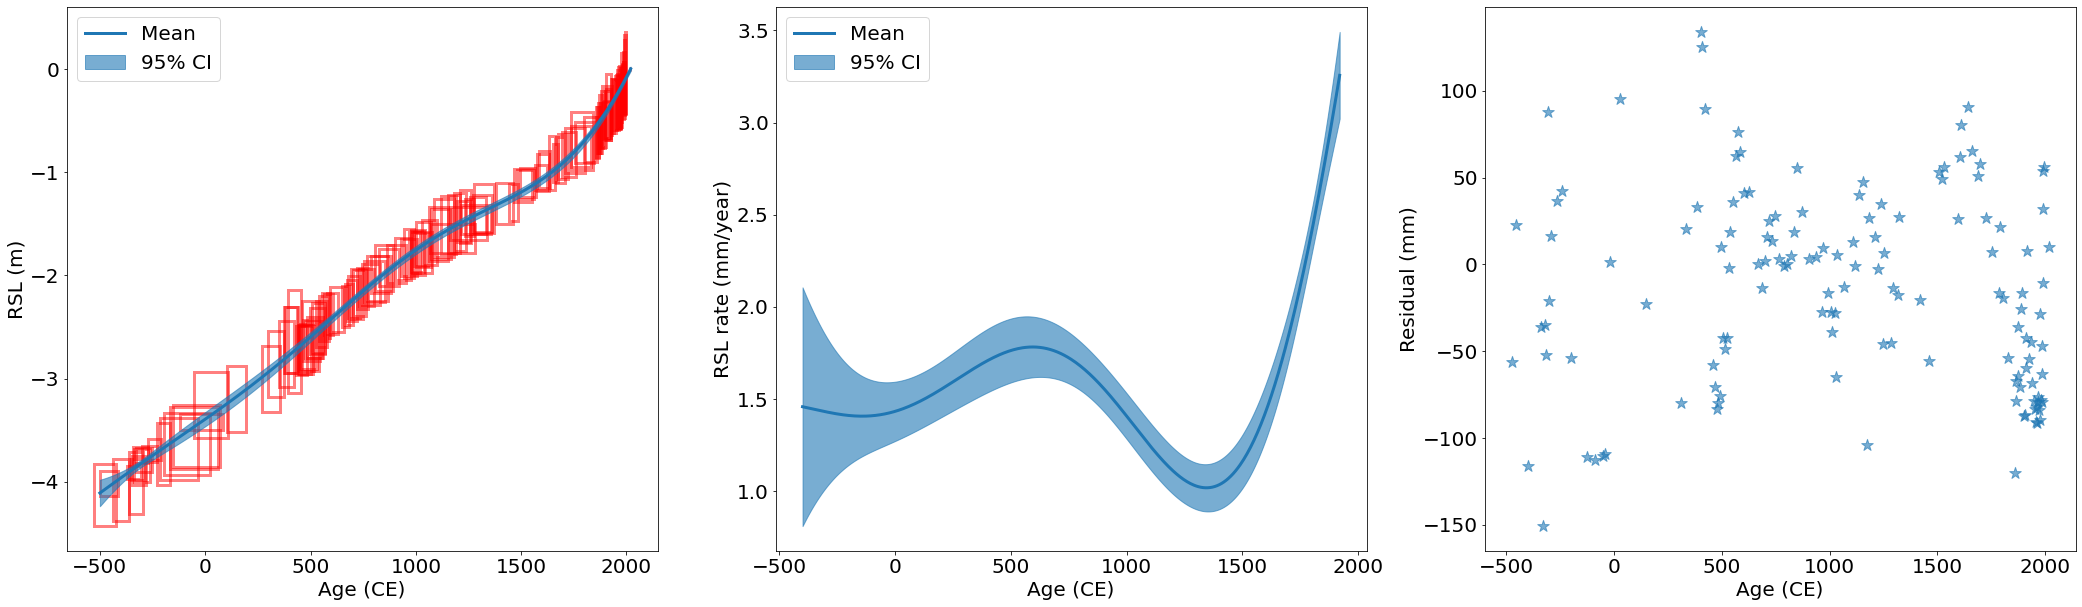

In [13]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

axes = PSTHM.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,c_kernel_y_mean,c_kernel_sd,
                          rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd)